In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
#export
from exp.nb_04Magda_corrected import *
from exp.nb_05bMagda import *
from exp.nb_06Magda import *
from exp.nb_06bMagda import *

In [3]:
#export
def quick_mnist_data():
    train_x, train_y, valid_x, valid_y, test_x, test_y = get_mnist()
    train_x, valid_x, test_x = norm_all(train_x, valid_x, test_x)
    mnist_bunch = DataBunch(train_x, train_y, valid_x, valid_y, 512)
    return mnist_bunch

In [4]:
mnist_bunch = quick_mnist_data()

## convnet

In [5]:
device = torch.device('cuda')
# cb_list = [CudaCallback(device), ReshapeMnist(), LossCallback(), AccuracyCallback()]
cb_list = [ReshapeMnist(), LossCallback(), AccuracyCallback()]
# cb_list.append(HooksCallback())
learner_cnn = LearnerCnn(mnist_bunch, cb_list)

In [6]:
%time learner_cnn.fit(2)

train:  2.177896738052368 validation:  2.095982313156128
train:  0.3279660642147064 validation:  0.4439544379711151
Final accuracy: 0.862400
CPU times: user 50.5 s, sys: 4.76 s, total: 55.2 s
Wall time: 5.07 s


In [7]:
device = torch.device('cuda')
cb_list = [ReshapeMnist(), LossCallback(), AccuracyCallback(), CudaCallback(device)]
# cb_list.append(HooksCallback())
learner_cnn_cuda = LearnerCnn(mnist_bunch, cb_list)

In [8]:
%time learner_cnn_cuda.fit(2)

train:  1.2705023288726807 validation:  1.149843692779541
train:  0.15116509795188904 validation:  0.1933184117078781
Final accuracy: 0.940200
CPU times: user 5.04 s, sys: 642 ms, total: 5.68 s
Wall time: 4.51 s


In [9]:
device = torch.device('cuda')
# cb_list = [CudaCallback(device), LossCallback(), AccuracyCallback()]
cb_list = [LossCallback(), AccuracyCallback()]
# cb_list.append(HooksCallback())
learner = Learner(mnist_bunch, cb_list)

In [10]:
%time learner.fit(2)

train:  0.35257065296173096 validation:  0.2570458948612213
train:  0.23675437271595 validation:  0.20319823920726776
Final accuracy: 0.937500
CPU times: user 8.94 s, sys: 190 ms, total: 9.13 s
Wall time: 1.19 s


In [11]:
device = torch.device('cuda')
cb_list = [LossCallback(), AccuracyCallback(), CudaCallback(device)]
# cb_list.append(HooksCallback())
learner_cuda = Learner(mnist_bunch, cb_list)

In [12]:
%time learner_cuda.fit(2)

train:  0.3240273594856262 validation:  0.34090080857276917
train:  0.2504191994667053 validation:  0.20688867568969727
Final accuracy: 0.938500
CPU times: user 1.94 s, sys: 33.2 ms, total: 1.97 s
Wall time: 918 ms


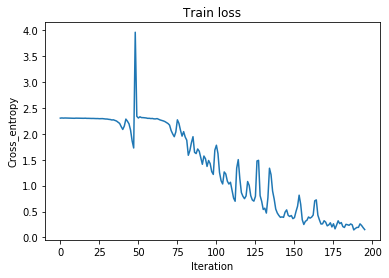

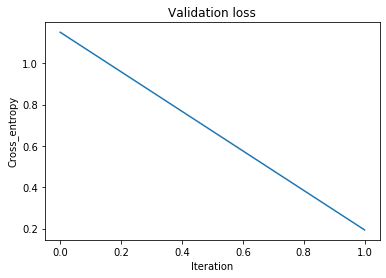

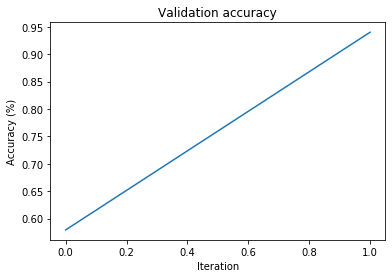

In [13]:
learner_cnn_cuda.plot_train_loss()
learner_cnn_cuda.plot_validation_loss()
learner_cnn_cuda.plot_accuracy()

## initialization

In [14]:
#export
from torch.nn import init
def init_model_params(model, uniform=False):
    for layer in model.children():
        if hasattr(layer, 'weight'):
            if uniform:
                init.kaiming_uniform_(layer.weight)
            else:
                init.kaiming_normal_(layer.weight)
        if getattr(layer, 'bias', None) is not None:
            init.zeros_(layer.bias)

In [15]:
for layer in learner_cnn_cuda.model.children():
    print(layer.bias)
    print(layer.bias.grad)
    break

Parameter containing:
tensor([-0.1226, -0.0978,  0.0348,  0.0878, -0.1370, -0.1238,  0.2322, -0.1127],
       device='cuda:0', requires_grad=True)
tensor([0., 0., 0., 0., 0., 0., 0., 0.], device='cuda:0')


In [16]:
init_model_params(learner_cnn_cuda.model)

In [17]:
learner_cnn_cuda.fit(2)

train:  0.1810850352048874 validation:  0.22436928749084473
train:  0.09971096366643906 validation:  0.1240433007478714
Final accuracy: 0.962100


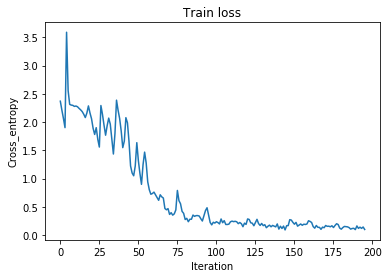

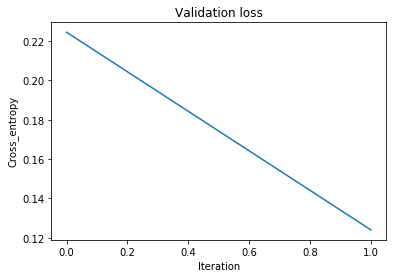

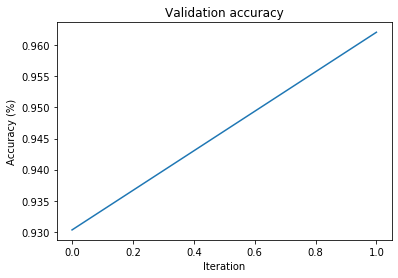

In [18]:
learner_cnn_cuda.plot_train_loss()
learner_cnn_cuda.plot_validation_loss()
learner_cnn_cuda.plot_accuracy()

## refactoring hooks

In [19]:
#export
class Hook():
    def __init__(self, layer, forward=False, backward=False):
        self.forward = forward
        self.backward = backward
        self.hook_forward = layer.register_forward_hook(self.forward_hook) if forward else None
        self.hook_backward = layer.register_forward_hook(self.backward_hook) if backward else None
    
    def __del__(self):
        self.remove()
        
    def remove(self):
        if self.forward:
            self.hook_forward.remove()
        if self.backward:
            self.hook_backward.remove()
        
    @staticmethod
    def forward_hook(self, *args):
        pass

    @staticmethod
    def backward_hook(self, *args):
        pass
    

In [20]:
#export
class OutputStatsHook(Hook):
    def __init__(self, layer, forward=True, backward=False):
        super(OutputStatsHook, self).__init__(layer, forward, backward)       

    @staticmethod
    def forward_hook(self, inputs, outputs):
        if not hasattr(self, 'output_stats'):
            self.output_stats = {'means': [], 'stds': []}
        self.output_stats['means'].append(outputs.mean().item())
        self.output_stats['stds'].append(outputs.std().item())   

In [21]:
#export
class HooksCallback(Callback):
    def __init__(self, hookname):
        self.hookname = hookname
    
    def fit_begin(self):
        self.hooks_forward = [self.hookname(x, self.hookname.forward_hook) for x in self.learner.model.children()]
        self.hooks_backward = [self.hookname(x, self.hookname.backward_hook) for x in self.learner.model.children()]
        self.hooks_forward
    
    def fit_end(self):
        for hook in self.hooks_forward:
            hook.remove()
        for hook in self.hooks_backward:
            hook.remove()

In [22]:
cb_list.pop()

In [23]:
cb_list

In [24]:
cb_list.append(HooksCallback(OutputStatsHook))

In [25]:
learner_cuda = Learner(mnist_bunch, cb_list)

In [26]:
learner_cuda.fit(5)

train:  0.4697776436805725 validation:  0.42088782787323
train:  0.2491365671157837 validation:  0.21997195482254028
train:  0.19530661404132843 validation:  0.18689972162246704
train:  0.15133507549762726 validation:  0.16713351011276245
train:  0.169667586684227 validation:  0.14959537982940674
Final accuracy: 0.955100


In [31]:
learner_cuda.__dict__

{'data_bunch': <exp.nb_04Magda_corrected.DataBunch at 0x7f5e15feadd0>,
 'classes': 10,
 'model': Sequential(
   (0): Linear(in_features=784, out_features=50, bias=True)
   (1): ReLU()
   (2): Linear(in_features=50, out_features=10, bias=True)
 ),
 'optimizer': SGD (
 Parameter Group 0
     dampening: 0
     lr: 0.5
     momentum: 0
     nesterov: False
     weight_decay: 0
 ),
 'loss_func': <function torch.nn.functional.cross_entropy(input, target, weight=None, size_average=None, ignore_index=-100, reduce=None, reduction='mean')>,
 'callback_list': [<exp.nb_05bMagda.LossCallback at 0x7f5e05be7dd0>,
 'epoch': 4,
 'batch_x': tensor([[-0.4245, -0.4245, -0.4245,  ..., -0.4245, -0.4245, -0.4245],
         [-0.4245, -0.4245, -0.4245,  ..., -0.4245, -0.4245, -0.4245],
         [-0.4245, -0.4245, -0.4245,  ..., -0.4245, -0.4245, -0.4245],
         ...,
         [-0.4245, -0.4245, -0.4245,  ..., -0.4245, -0.4245, -0.4245],
         [-0.4245, -0.4245, -0.4245,  ..., -0.4245, -0.4245, -0.4245],
 

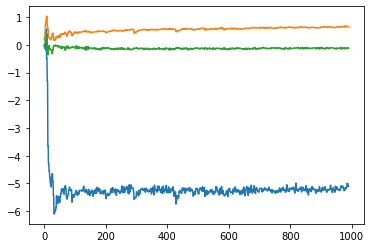

In [34]:
for layer in learner_cuda.model.children():
    plt.plot(layer.output_stats['means'])

In [43]:
cb_list = [ReshapeMnist(), LossCallback(), AccuracyCallback(), CudaCallback(device)]

In [44]:
cb_list.append(HooksCallback(OutputStatsHook))
learner_cnn_cuda = LearnerCnn(mnist_bunch, cb_list)

In [45]:
learner_cnn_cuda.fit(10)

train:  1.476521611213684 validation:  2.486969232559204
train:  0.5091742873191833 validation:  0.3775493800640106
train:  0.0925888642668724 validation:  0.11519980430603027
train:  0.08345863968133926 validation:  0.0941580981016159
train:  0.07234600931406021 validation:  0.08105148375034332
train:  0.10536569356918335 validation:  0.08143898099660873
train:  0.053853731602430344 validation:  0.06937253475189209
train:  0.1304205060005188 validation:  0.1138017326593399
train:  0.0466509610414505 validation:  0.07465615123510361
train:  0.04059494286775589 validation:  0.07029304653406143
Final accuracy: 0.979600


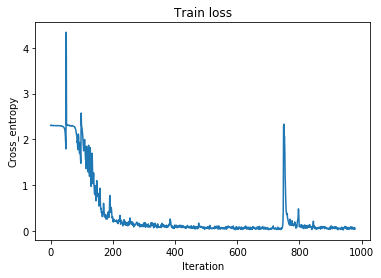

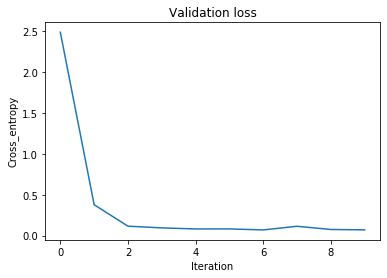

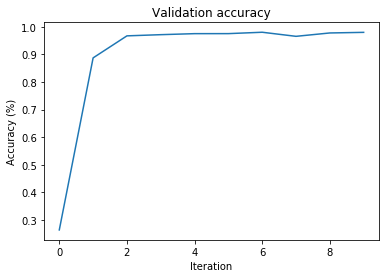

In [46]:
learner_cnn_cuda.plot_train_loss()
learner_cnn_cuda.plot_validation_loss()
learner_cnn_cuda.plot_accuracy()

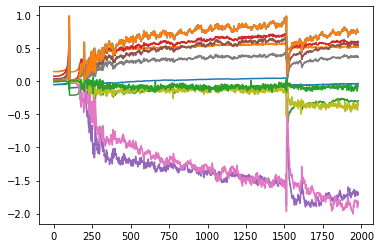

In [47]:
for layer in learner_cnn_cuda.model.children():
    plt.plot(layer.output_stats['means'])

In [ ]:
nb_auto_export()